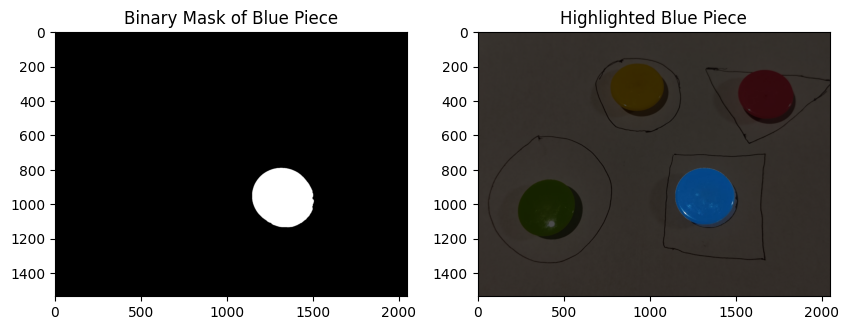

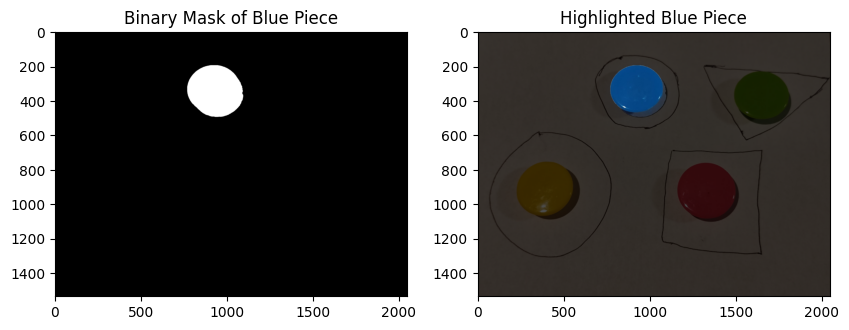

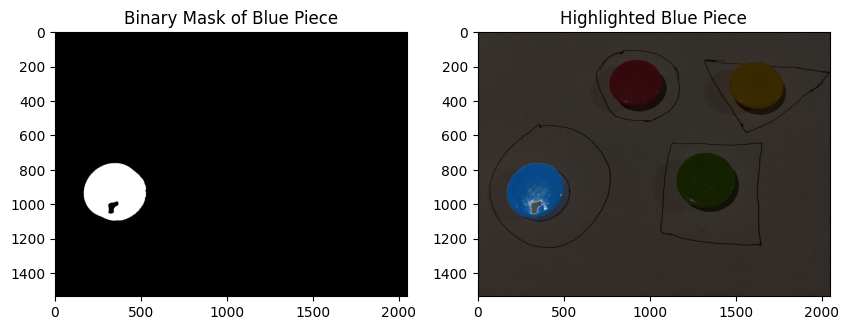

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def locate_blue_piece(image_path):
    """Detects and refines the blue piece mask."""
    # Load the image
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define blue color range (HSV)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    # Create binary mask for blue detection
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Apply morphological operations to refine the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # Increased size for better noise removal
    blue_mask_cleaned = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)  # Closing to fill holes
    blue_mask_cleaned = cv2.morphologyEx(blue_mask_cleaned, cv2.MORPH_OPEN, kernel)  # Opening to remove noise

    # (b) Visualize the blue piece by darkening other pixels
    result = image.copy()
    result[np.where(blue_mask_cleaned == 0)] = result[np.where(blue_mask_cleaned == 0)] * 0.3  # Reduce intensity

    return blue_mask_cleaned, result

def process_part1():
    images = ["image_1.jpeg", "image_2.jpeg", "image_3.jpeg"]
    
    for img in images:
        blue_mask, blue_highlighted = locate_blue_piece(img)

        # Display results
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(blue_mask, cmap='gray')
        plt.title("Binary Mask of Blue Piece")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(blue_highlighted, cv2.COLOR_BGR2RGB))
        plt.title("Highlighted Blue Piece")

        plt.show()

# Run Part 1
process_part1()

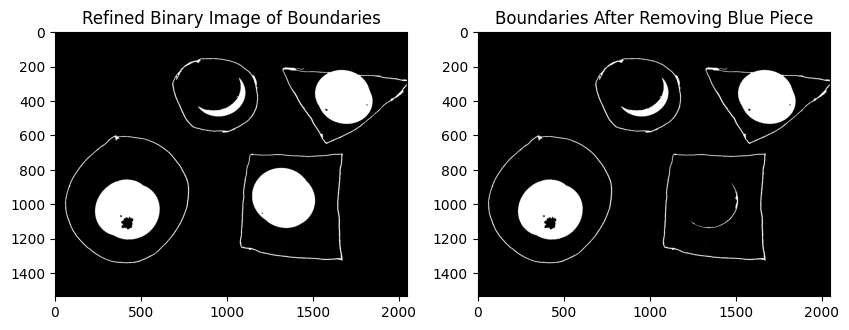

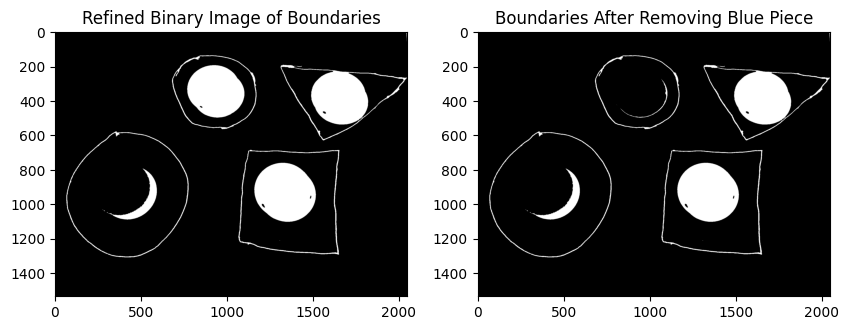

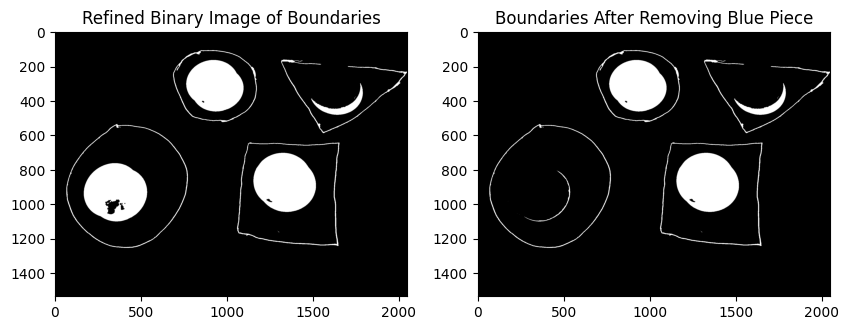

In [2]:
def locate_boundaries(image_path, blue_mask):
    """Finds the boundaries of shapes while removing the blue piece."""
    # Load image and convert to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding (Otsu's method)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological closing to ensure boundaries are connected
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    binary_closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Remove blue piece from boundary image
    binary_cleaned = cv2.bitwise_and(binary_closed, cv2.bitwise_not(blue_mask))

    return binary_closed, binary_cleaned

def process_part2():
    images = ["image_1.jpeg", "image_2.jpeg", "image_3.jpeg"]
    
    for img in images:
        blue_mask, _ = locate_blue_piece(img)
        boundaries, boundaries_cleaned = locate_boundaries(img, blue_mask)

        # Display results
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(boundaries, cmap='gray')
        plt.title("Refined Binary Image of Boundaries")

        plt.subplot(1, 2, 2)
        plt.imshow(boundaries_cleaned, cmap='gray')
        plt.title("Boundaries After Removing Blue Piece")

        plt.show()

# Run Part 2
process_part2()

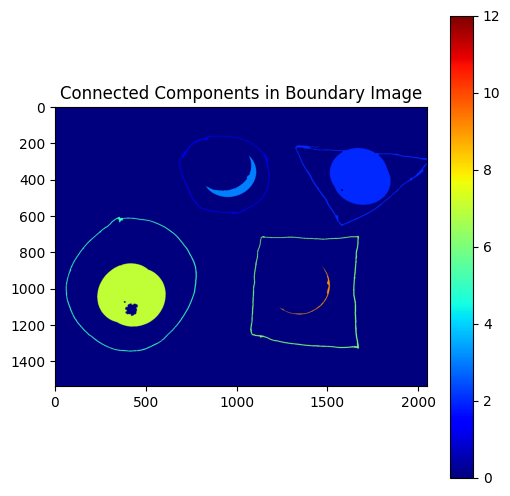

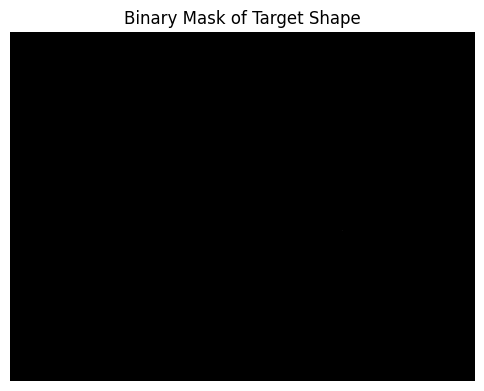

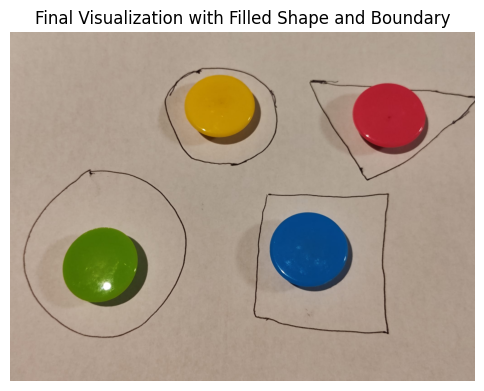

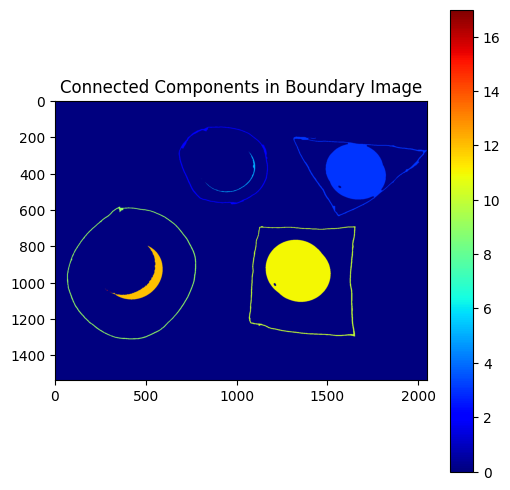

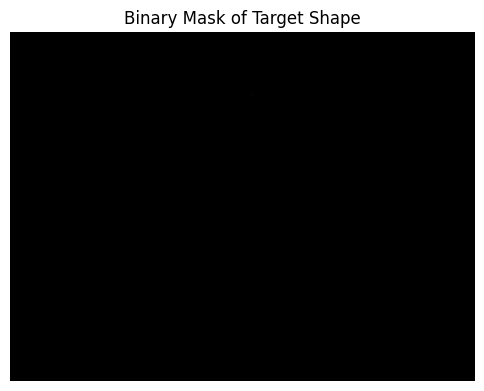

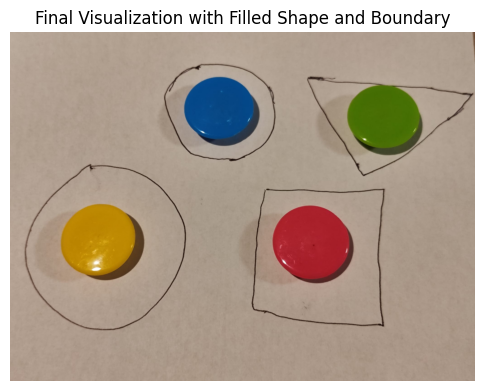

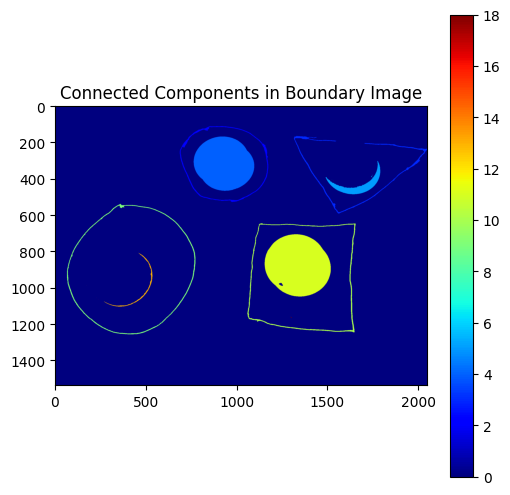

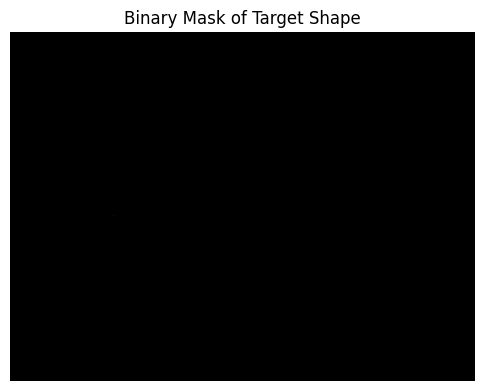

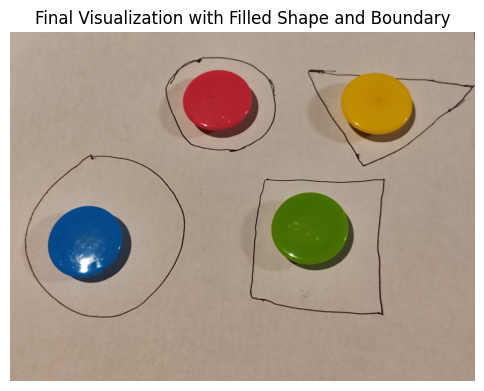

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_target_shape(boundary_image, blue_mask):
    """Identifies the shape that contains the blue piece using connected components analysis."""
    
    # Ensure the boundary shapes are fully closed
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))  
    boundary_closed = cv2.morphologyEx(boundary_image, cv2.MORPH_CLOSE, kernel_close)

    # Perform connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(boundary_closed, connectivity=8)

    # Debug: Show connected components
    plt.figure(figsize=(6, 6))
    plt.title("Connected Components in Boundary Image")
    plt.imshow(labels, cmap='jet')
    plt.colorbar()
    plt.show()

    # Dilate the blue mask slightly to ensure overlap with the shape
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  
    blue_mask_dilated = cv2.dilate(blue_mask, kernel_dilate, iterations=2)

    # Identify the shape that contains the blue piece
    target_label = None
    for label in range(1, num_labels):  
        mask = (labels == label).astype(np.uint8) * 255
        overlap = cv2.bitwise_and(mask, blue_mask_dilated)  

        if np.any(overlap):  
            target_label = label
            break

    if target_label is not None:
        shape_mask = (labels == target_label).astype(np.uint8) * 255
        return shape_mask, target_label, labels
    else:
        print("Error: No shape found containing the blue piece! Retrying with more dilation.")
        return None, None, None

def visualize_target_shape(image, shape_mask, blue_mask, target_label, labels):
    """Visualizes the shape containing the blue piece by changing its color."""
    if shape_mask is not None:
        # Show binary mask of the detected shape
        plt.figure(figsize=(6, 6))
        plt.title("Binary Mask of Target Shape")
        plt.imshow(shape_mask, cmap='gray')
        plt.axis("off")
        plt.show()

        # Fill the detected shape, ensuring the boundary is included
        filled_image = image.copy()
        filled_image[labels == target_label] = [0, 0, 255]  

        # Preserve the blue piece color
        filled_image[blue_mask == 255] = image[blue_mask == 255]

        # Show final visualization
        plt.figure(figsize=(6, 6))
        plt.title("Final Visualization with Filled Shape and Boundary")
        plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

def process_part3():
    """Processes all images and applies connected components analysis from Part 2 boundaries."""
    images = ["image_1.jpeg", "image_2.jpeg", "image_3.jpeg"]
    for img in images:
        blue_mask, _ = locate_blue_piece(img)  
        boundaries, boundaries_cleaned = locate_boundaries(img, blue_mask)  

        # Run target shape detection
        shape_mask, target_label, labels = find_target_shape(boundaries_cleaned, blue_mask)

        if shape_mask is not None:
            visualize_target_shape(cv2.imread(img), shape_mask, blue_mask, target_label, labels)

# Run Part 3
process_part3()